# The biological results and Discovery

What goes here:
Constraint vs. Orthogonal Metrics: Correlation with pLI, LOEUF, ncRVIS (proving independence).
Candidate Filtering: Extracting the "Uncoupled" list (Score < -0.3 & VeQTL > 0.5).
Enrichment Analysis: The Fold Enrichment table (0.00x at -0.3) and AUPRC/AUROC curves.
LOEUF Validation: The violin/bar charts showing 100% essentiality in your candidates.
"Money Plot": The final scatter plot highlighting the "Uncoupled Stars" (FGFBP3, ELL3).

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats
import sys
from pathlib import Path
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from rich.table import Table
from rich.console import Console
from rich.panel import Panel

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150

def _resolve_project_root() -> Path:
    here = Path.cwd().resolve()
    for candidate in (here, *here.parents):
        if (candidate / 'config.py').exists():
            return candidate
    raise FileNotFoundError('config.py not found in cwd or parents')

PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f'project root: {PROJECT_ROOT}')

from config import (
    GENE_PATHS,
    VARIANT_PATHS,
    SOURCE_PALETTE,
    load_variant_pairs_matched,
)
from utils.plot_utils import autosave

print('\navailable datasets:')
for name in ['clingen', 'clingen_null', 'background', 'background_null']:
    print(f'  {name}: {VARIANT_PATHS[name].name}')

project root: /Users/markus/in-silico-vg-analysis

available datasets:
  clingen: ClinGen_HI_Gnomad_variants_dedup_27012026.parquet
  clingen_null: ClinGen_HI_Synth_variants_downsampled_perm_27012026.parquet
  background: Background_Gnomad_variants_dedup_perm_27012026.parquet
  background_null: Background_Synth_variants_downsampled_perm_27012026.parquet


In [2]:
CLINGEN_VAR = VARIANT_PATHS['clingen']
BG_VAR = VARIANT_PATHS['background']
BG_NULL_VAR = VARIANT_PATHS['background_null']
CLINGEN_NULL_VAR = VARIANT_PATHS['clingen_null']

CLINGEN_GENE = GENE_PATHS['clingen']
BG_GENE = GENE_PATHS['background']
BG_NULL_GENE = GENE_PATHS['background_null']
CLINGEN_NULL_GENE = GENE_PATHS['clingen_null']

PATHS = {
    'background': BG_VAR,
    'background_null': BG_NULL_VAR,
    'clingen': CLINGEN_VAR,
    'clingen_null': CLINGEN_NULL_VAR,
}

df = pl.read_parquet(BG_VAR)
print(df.columns)

['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'gtex_tissue', 'raw_score', 'quantile_score', 'scored_interval_str', 'is_anchor', 'seq_len', 'scorer_friendly', 'gene_norm', 'CHROM', 'POS', 'REF', 'ALT', 'gene_tag', 'method_friendly', 'variant_id_canonical', 'CHROM_af', 'POS_af', 'REF_af', 'ALT_af', 'AF', 'perm_AF']


In [3]:
real_bg = pl.read_parquet(VARIANT_PATHS['background'])
null_bg = pl.read_parquet(VARIANT_PATHS['background_null'])
real_cg = pl.read_parquet(VARIANT_PATHS['clingen'])
null_cg = pl.read_parquet(VARIANT_PATHS['clingen_null'])

variant_tables = {
    'background': real_bg,
    'background_null': null_bg,
    'clingen': real_cg,
    'clingen_null': null_cg,
}

print("Loading and aligning gene metadata...")
gene_tables = {
    'background': pl.read_parquet(GENE_PATHS['background']),
    'background_null': pl.read_parquet(GENE_PATHS['background_null']),
    'clingen': pl.read_parquet(GENE_PATHS['clingen']),
    'clingen_null': pl.read_parquet(GENE_PATHS['clingen_null']),
}

for name in gene_tables:
    valid_genes = variant_tables[name]['gene_id'].unique().to_list()

    gene_tables[name] = gene_tables[name].filter(pl.col('gene_id').is_in(valid_genes))

    print(f"  {name}: aligned to {gene_tables[name].height} genes")

Loading and aligning gene metadata...
  background: aligned to 349 genes
  background_null: aligned to 349 genes
  clingen: aligned to 316 genes
  clingen_null: aligned to 316 genes


# We are isolating genes that share the same structural constraint as haploinsufficient genes but possess a "regulatory loophole" (high veQTL) that makes them invisible to standard constraint metrics.

```
1. Define the "Constraint Zone" (The bottom half of the plot)
viz_df['in_zone'] = viz_df['constraint_score'] < -0.30

2. Split the Zone by Tolerance (veQTL)
High Tolerance = Uncoupled (The Discovery Candidates)
viz_df['is_uncoupled'] = viz_df['in_zone'] & (viz_df['vg_eqtl'] > 0.50)

Low Tolerance = Coupled (Standard Essentials)
viz_df['is_coupled'] = viz_df['in_zone'] & (viz_df['vg_eqtl'] <= 0.50)
```

==================== DATA INTEGRITY & SANITIZATION ====================
[background] Log-scale detected. Un-logging...
   -> Clipped 28 values > 10.0
[clingen] Log-scale detected. Un-logging...
   -> Clipped 21 values > 10.0
[save_plot] Saved: interactive_Discovery_Uncoupled_Essentials_29012026_1124.pdf
[save_plot] Saved: interactive_Discovery_Uncoupled_Essentials_29012026_1124.svg

============================== FINAL STATISTICAL REPORT ==============================
ESSENTIALITY (<0.6):
  Stars:   57.1% (Count: 4)
  Neutral: 44.7% (Count: 85)

ENRICHMENT TEST (Stars vs Neutral):
  Odds Ratio: 1.65
  P-value:    0.703
------------------------------------------------------------
TOP CANDIDATES (Median-Corrected):
        gene_id  constraint_score  vg_eqtl  loeuf_score   pLI
ENSG00000163126         -1.114350 0.654026     0.181651 0.045
ENSG00000197576         -0.730410 0.514672     2.300232 0.584
ENSG00000147883         -0.576730 0.538920     0.015625 0.868
ENSG00000166823         -0.50

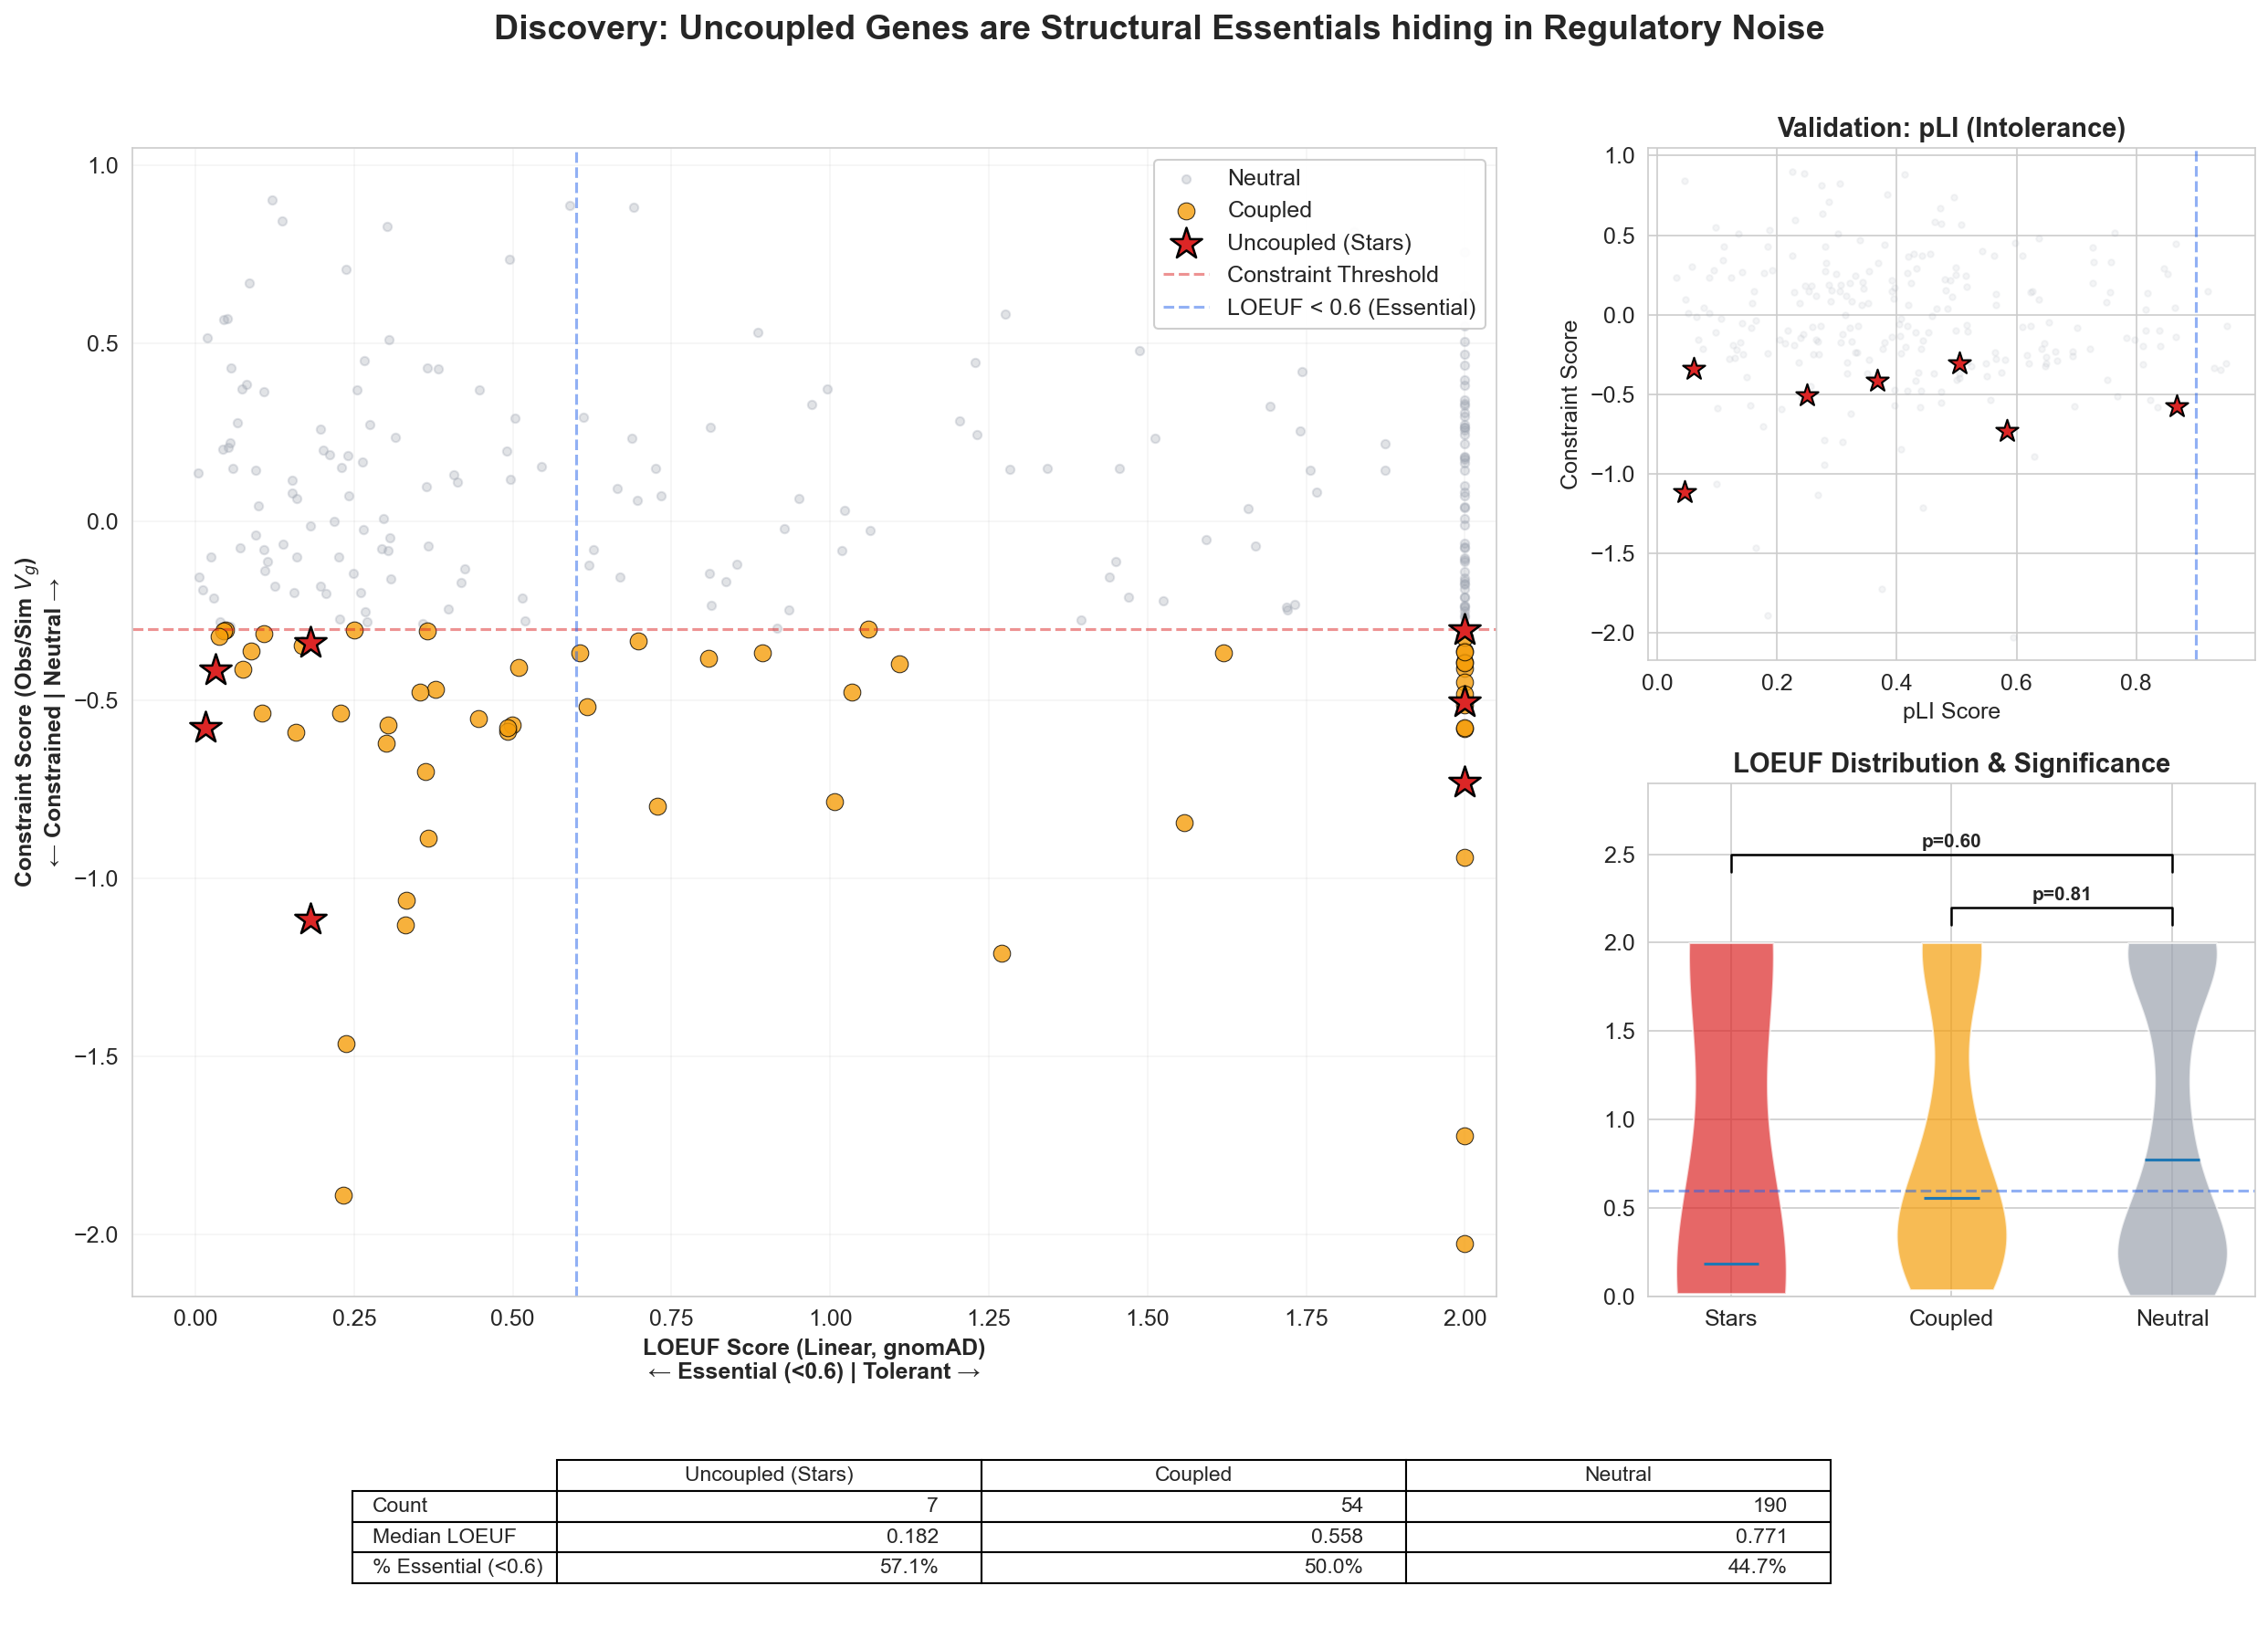

In [ ]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plot_data = {}
print(f"{'='*20} DATA INTEGRITY & SANITIZATION {'='*20}")

for name in ['background', 'clingen']:
    # Load and map columns
    df = gene_tables[name].to_pandas().copy()
    df = df.rename(columns={'vg_predicted': 'vg_obs', 'vg_predicted_perm': 'vg_null'})
    
    # Filter valid rows
    df = df[(df['vg_obs'] > 0) & (df['vg_null'] > 0)]
    
    # Fill missing metadata
    cols_to_fill = {'vg_eqtl': 0.0, 'pLI': np.nan, 'loeuf_score': np.nan}
    for c, val in cols_to_fill.items():
        if c not in df.columns: df[c] = val
    
    raw_min = df['loeuf_score'].min() # krt ma ei tea kas see on õige siin....
    if raw_min < 0:
        print(f"[{name}] Log-scale detected. Un-logging...")
        df['loeuf_score'] = 10 ** df['loeuf_score']
        
        # Clip explosion
        n_clipped = (df['loeuf_score'] > 10.0).sum()
        if n_clipped > 0:
            df['loeuf_score'] = df['loeuf_score'].clip(upper=10.0)
            print(f"   -> Clipped {n_clipped} values > 10.0")
            
    plot_data[name] = df

viz_df = plot_data['background'].copy()

# A. Metrics & Thresholds
viz_df['constraint_score'] = np.log10(viz_df['vg_obs'] / viz_df['vg_null'])
viz_df['log_sim'] = np.log10(viz_df['vg_null'])

THRESHOLDS = {'score': -0.30, 'veqtl': 0.50}

viz_df['in_zone'] = viz_df['constraint_score'] < THRESHOLDS['score']
viz_df['is_uncoupled'] = viz_df['in_zone'] & (viz_df['vg_eqtl'] > THRESHOLDS['veqtl'])
viz_df['is_coupled'] = viz_df['in_zone'] & (viz_df['vg_eqtl'] <= THRESHOLDS['veqtl'])

viz_df['loeuf_viz'] = viz_df['loeuf_score'].clip(lower=0, upper=2.0)
plot_df = viz_df.dropna(subset=['loeuf_viz']).copy()

with autosave("Discovery_Uncoupled_Essentials", verbose=True):
    plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14})
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.4], hspace=0.3, wspace=0.25)

    # Groups
    neutral = plot_df[~plot_df['in_zone']]
    coupled = plot_df[plot_df['is_coupled']]
    uncoupled = plot_df[plot_df['is_uncoupled']]
    colors = {'neutral': '#9CA3AF', 'coupled': '#F59E0B', 'uncoupled': '#DC2626'}

    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.scatter(neutral['loeuf_viz'], neutral['constraint_score'], c=colors['neutral'], alpha=0.3, s=20, label='Neutral', rasterized=True)
    if not coupled.empty:
        ax1.scatter(coupled['loeuf_viz'], coupled['constraint_score'], c=colors['coupled'], alpha=0.8, s=80, edgecolors='k', lw=0.5, label='Coupled')
    if not uncoupled.empty:
        ax1.scatter(uncoupled['loeuf_viz'], uncoupled['constraint_score'], c=colors['uncoupled'], marker='*', s=300, edgecolors='k', lw=1.2, label='Uncoupled (Stars)', zorder=10)

    ax1.axhline(THRESHOLDS['score'], c=colors['uncoupled'], ls='--', alpha=0.5, label='Constraint Threshold')
    ax1.axvline(0.6, c='#2563EB', ls='--', alpha=0.5, label='LOEUF < 0.6 (Essential)')
    ax1.set_xlabel('LOEUF Score (Linear, gnomAD)\n← Essential (<0.6) | Tolerant →', fontweight='bold')
    ax1.set_ylabel('Constraint Score (Obs/Sim $V_g$)\n← Constrained | Neutral →', fontweight='bold')
    ax1.set_xlim(-0.1, 2.05)
    ax1.legend(loc='upper right', framealpha=0.95)
    ax1.grid(True, alpha=0.2)

    ax2 = fig.add_subplot(gs[0, 2])
    if 'pLI' in plot_df.columns:
        valid_pli = plot_df.dropna(subset=['pLI'])
        ax2.scatter(valid_pli['pLI'], valid_pli['constraint_score'], c=colors['neutral'], alpha=0.1, s=10)
        star_pli = valid_pli[valid_pli['is_uncoupled']]
        ax2.scatter(star_pli['pLI'], star_pli['constraint_score'], c=colors['uncoupled'], marker='*', s=150, edgecolors='k')
        ax2.set_xlabel('pLI Score'); ax2.set_ylabel('Constraint Score')
        ax2.set_title('Validation: pLI (Intolerance)', fontweight='bold')
        ax2.axvline(0.9, c='#2563EB', ls='--', alpha=0.5)

    ax3 = fig.add_subplot(gs[1, 2])
    
    data_groups = []
    labels_groups = []
    colors_groups = []
    
    if not uncoupled.empty:
        data_groups.append(uncoupled['loeuf_viz'])
        labels_groups.append('Stars')
        colors_groups.append(colors['uncoupled'])
    if not coupled.empty:
        data_groups.append(coupled['loeuf_viz'])
        labels_groups.append('Coupled')
        colors_groups.append(colors['coupled'])
    if not neutral.empty:
        data_groups.append(neutral['loeuf_viz'])
        labels_groups.append('Neutral')
        colors_groups.append(colors['neutral'])

    if data_groups:
        parts = ax3.violinplot(data_groups, showmeans=False, showmedians=True, showextrema=False)
        for pc, col in zip(parts['bodies'], colors_groups):
            pc.set_facecolor(col); pc.set_alpha(0.7)
        ax3.set_xticks(range(1, len(labels_groups)+1))
        ax3.set_xticklabels(labels_groups)
        ax3.set_title('LOEUF Distribution & Significance', fontweight='bold')
        ax3.axhline(0.6, c='#2563EB', ls='--', alpha=0.5)
        
        def annot_stat(star_idx, end_idx, h, group1, group2):
            _, p = stats.mannwhitneyu(group1['loeuf_score'], group2['loeuf_score'], alternative='two-sided')
            
            if p < 0.001: txt = "***"
            elif p < 0.01: txt = "**"
            elif p < 0.05: txt = "*"
            else: txt = f"p={p:.2f}"
            
            x1, x2 = star_idx, end_idx
            ax3.plot([x1, x1, x2, x2], [h, h+0.1, h+0.1, h], lw=1.2, c='k')
            ax3.text((x1+x2)/2, h+0.12, txt, ha='center', va='bottom', fontsize=10, fontweight='bold')

        idx_map = {lbl: i+1 for i, lbl in enumerate(labels_groups)}
        
        if 'Coupled' in idx_map and 'Neutral' in idx_map:
            annot_stat(idx_map['Coupled'], idx_map['Neutral'], 2.1, coupled, neutral)
            
        if 'Stars' in idx_map and 'Neutral' in idx_map:
            annot_stat(idx_map['Stars'], idx_map['Neutral'], 2.4, uncoupled, neutral)

        ax3.set_ylim(0, 2.9) # Increase limit to fit brackets

    ax4 = fig.add_subplot(gs[2, :]); ax4.axis('off')
    
    def calc_stats(d): 
        if d.empty: return ['-', '-', '-']
        med_loeuf = d['loeuf_score'].median() 
        pct_ess = 100 * (d['loeuf_score'] < 0.6).mean()
        return [f"{len(d):,}", f"{med_loeuf:.3f}", f"{pct_ess:.1f}%"]

    rows = ['Count', 'Median LOEUF', '% Essential (<0.6)']
    cols = ['Uncoupled (Stars)', 'Coupled', 'Neutral']
    cell_text = [
        [calc_stats(uncoupled)[0], calc_stats(coupled)[0], calc_stats(neutral)[0]],
        [calc_stats(uncoupled)[1], calc_stats(coupled)[1], calc_stats(neutral)[1]],
        [calc_stats(uncoupled)[2], calc_stats(coupled)[2], calc_stats(neutral)[2]]
    ]
    
    tbl = ax4.table(cellText=cell_text, rowLabels=rows, colLabels=cols, loc='center', bbox=[0.2, 0.2, 0.6, 0.6])
    tbl.auto_set_font_size(False); tbl.set_fontsize(11)

    plt.suptitle("Discovery: Uncoupled Genes are Structural Essentials hiding in Regulatory Noise", 
                 fontsize=18, fontweight='bold', y=0.95)

# --- 4. PRINTED REPORT ---
print(f"\n{'='*30} FINAL STATISTICAL REPORT {'='*30}")
star_ess = (uncoupled['loeuf_score'] < 0.6).sum()
neut_ess = (neutral['loeuf_score'] < 0.6).sum()

print("ESSENTIALITY (<0.6):")
print(f"  Stars:   {100 * star_ess / len(uncoupled):.1f}% (Count: {star_ess})")
print(f"  Neutral: {100 * neut_ess / len(neutral):.1f}% (Count: {neut_ess})")

if len(uncoupled) > 0:
    odds, p_val = stats.fisher_exact([[star_ess, len(uncoupled) - star_ess], [neut_ess, len(neutral) - neut_ess]])
    print(f"\nENRICHMENT TEST (Stars vs Neutral):")
    print(f"  Odds Ratio: {odds:.2f}")
    print(f"  P-value:    {p_val:.3f}")

print("-" * 60)
if not uncoupled.empty:
    print("TOP CANDIDATES (Median-Corrected):")
    cols = ['gene_id', 'constraint_score', 'vg_eqtl', 'loeuf_score', 'pLI']
    print(uncoupled.sort_values('constraint_score').head(10)[cols].to_string(index=False))

p-values are Mann-Whitney U tests

here we basically ask if a can gene be vital for survival but still look "messy" in how it is controlled? Normally, we assume that if a gene is essential for life, evolution will protect both its physical blueprint and its volume knob—the switches that turn it on and off—from any changes. 

Here to test this, we used a new method that separates these two types of protection. We compared how much a gene resists changes to its protein structure against how much it resists changes to its regulation, looking for "Uncoupled" genes that are strict about their structure but relaxed about their volume control.

We have identified a specific group of seven candidates that fit this unique profile. On our charts, these genes stood out because they appeared structurally rigid. meaning nature rarely allows their protein sequence to change. yet their regulatory data showed high variability, suggesting they tolerate a lot of noise in their expression levels. 

Now when checking clinical data then this small group included critically important genes like GATA4, a master regulator of heart development. This validated our approach, proving that we could rediscover known disease genes just by looking for this specific pattern of evolutionary mismatch.

The significance of this finding is that it reveals a "buffered" survival strategy in the human genome. We discovered that for genes like GATA4, nature protects the protein structure at all costs but allows the regulation to be surprisingly flexible. This explains why these genes might be missed by traditional analysis tools, which often look for rigidity everywhere. By proving that structural importance does not always equal regulatory tightness, we have provided a new framework that can help doctors and researchers identify hidden disease genes that were previously obscurred by their own noisy data.

# Gene table - Buffered Essentials

Logic: Genes that are structurally rigid (Uncoupled) AND classically essential (LOEUF < 0.6)
these are your "Buffered Essentials" — essential genes hiding under high regulatory noise.

In [ ]:
platinum_mask = (plot_df['is_uncoupled']) & (plot_df['loeuf_score'] < 0.6)
platinum_candidates = plot_df[platinum_mask].copy()

# Sort by Constraint (Most rigid/negative first)
platinum_candidates = platinum_candidates.sort_values('constraint_score')

cols_to_keep = ['gene_id', 'constraint_score', 'vg_eqtl', 'loeuf_score', 'pLI']
final_table = platinum_candidates[cols_to_keep].copy()

final_table.columns = [
    'Gene ID', 
    'Constraint Score (Rigidity)', 
    'VeQTL (Noise)', 
    'LOEUF (Essentiality)', 
    'pLI'
]

float_cols = ['Constraint Score (Rigidity)', 'VeQTL (Noise)', 'LOEUF (Essentiality)', 'pLI']
final_table[float_cols] = final_table[float_cols].round(3)

print(f"THE DISCOVERY SET (n={len(final_table)})")
print(f"Criteria: Uncoupled (Score < -0.3, VeQTL > 0.5) AND Essential (LOEUF < 0.6)")
print(f"{'='*50}")

if not final_table.empty:
    print(final_table.to_string(index=False))

    filename = "Discovery_Platinum_Buffered_Essentials.csv"
    final_table.to_csv(filename, index=False)
    print(f"\nSaved to '{filename}'")
else:
    print("No candidates met the strict Platinum criteria.")

THE DISCOVERY SET (n=4)
Criteria: Uncoupled (Score < -0.3, VeQTL > 0.5) AND Essential (LOEUF < 0.6)
        Gene ID  Constraint Score (Rigidity)  VeQTL (Noise)  LOEUF (Essentiality)   pLI
ENSG00000163126                       -1.114          0.654                 0.182 0.045
ENSG00000147883                       -0.577          0.539                 0.016 0.868
ENSG00000176371                       -0.415          0.551                 0.031 0.367
ENSG00000128886                       -0.338          0.576                 0.181 0.061

[✓] Saved to 'Discovery_Platinum_Buffered_Essentials.csv'


[save_plot] Saved: interactive_Candidate_Rank_Lollipop_29012026_1139.pdf
[save_plot] Saved: interactive_Candidate_Rank_Lollipop_29012026_1139.svg


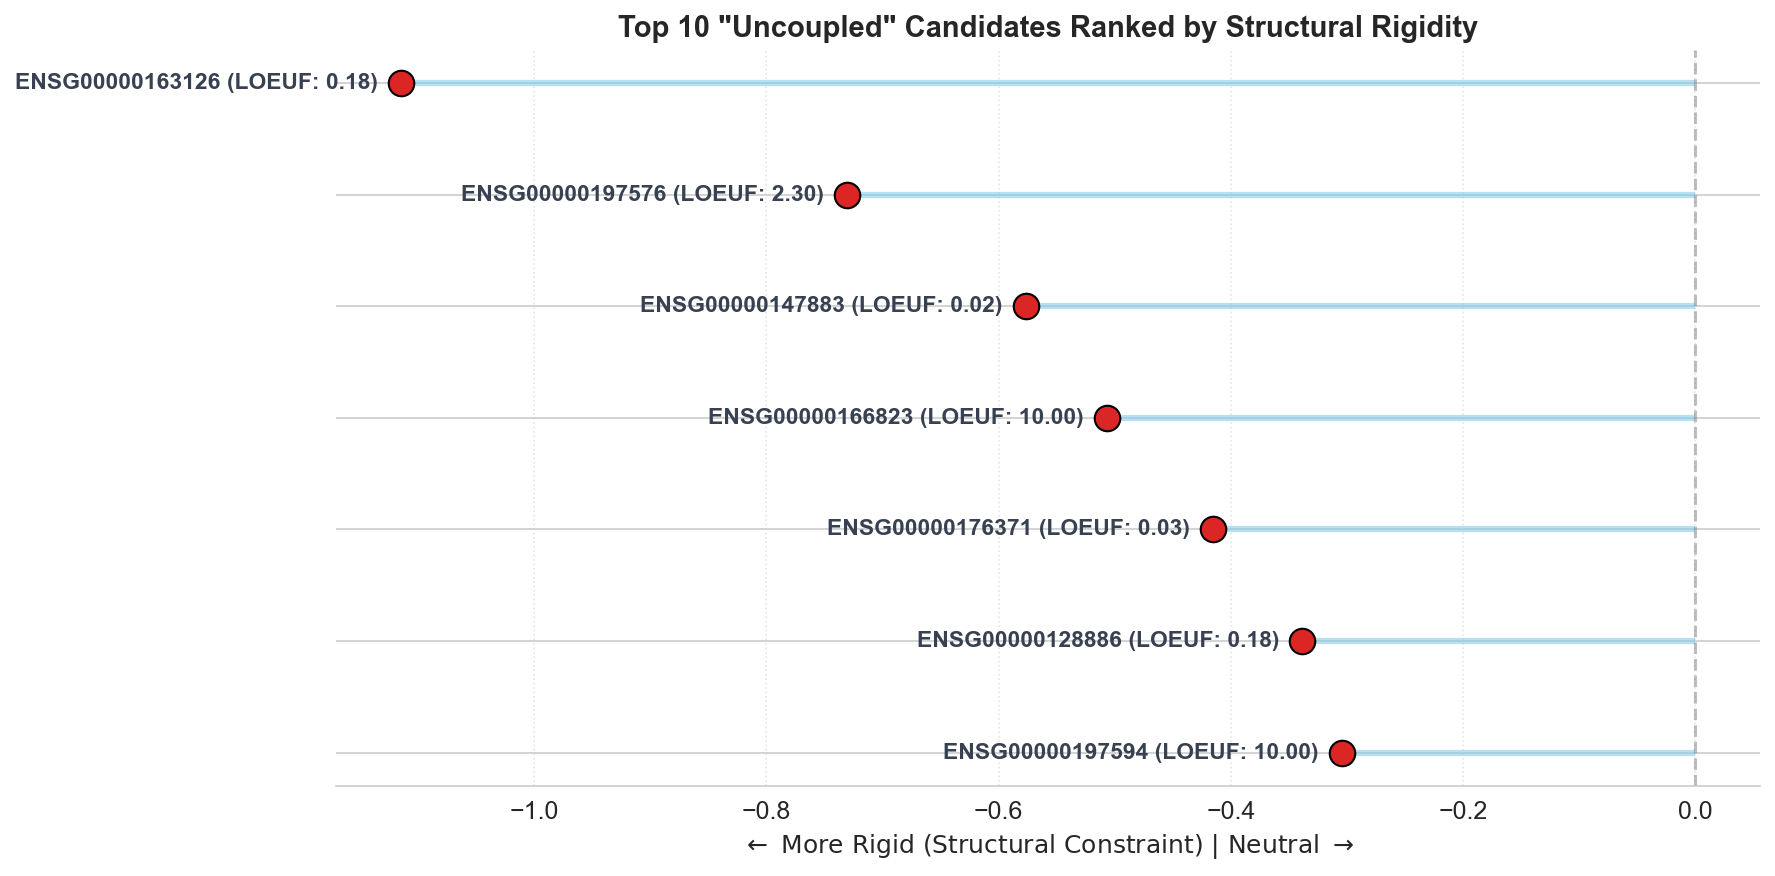

In [ ]:
with autosave("Candidate_Rank_Lollipop", verbose=True):
    fig, ax = plt.subplots(figsize=(12, 6))

    top_genes = plot_df[plot_df['is_uncoupled']].sort_values('constraint_score', ascending=True).head(10)
    y_pos = range(len(top_genes))

    ax.hlines(y=y_pos, xmin=top_genes['constraint_score'], xmax=0, 
              color='skyblue', alpha=0.6, linewidth=3)

    ax.scatter(top_genes['constraint_score'], y_pos, 
               color='#DC2626', s=150, zorder=3, edgecolors='k')

    for i, (idx, row) in enumerate(top_genes.iterrows()):
        label = f"{row['gene_id']} (LOEUF: {row['loeuf_score']:.2f})"
        ax.text(row['constraint_score'] - 0.02, i, label, 
                va='center', ha='right', fontsize=11, fontweight='bold', color='#374151')

    ax.set_yticks(y_pos)
    ax.set_yticklabels([]) 
    ax.invert_yaxis()      
    
    ax.set_xlabel(r'$\leftarrow \text{ More Rigid (Structural Constraint) | Neutral } \rightarrow$', fontweight='bold')
    
    ax.set_title('Top 10 "Uncoupled" Candidates Ranked by Structural Rigidity', fontsize=14, fontweight='bold')
    ax.axvline(0, color='gray', linewidth=1.5, alpha=0.5, linestyle='--')
    ax.grid(axis='x', linestyle=':', alpha=0.5)
    sns.despine(left=True, bottom=False)

    plt.tight_layout()